In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [82]:
# Daten einlesen
data <- read_csv("/Users/JonasIseli/Desktop/test_data.csv")
data <- data[2:7]
data %>% head()

New names:
• `` -> `...1`
Rows: 700000 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): betriebsdatum
dbl (6): ...1, linie, fahrzeug, soll_an_von, verspaetung, halt_id_von

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


linie,betriebsdatum,fahrzeug,soll_an_von,verspaetung,halt_id_von
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2,15.05.16,3007,17790,45,1306
2,15.05.16,3007,18180,0,2228
2,15.05.16,3007,18120,4,1528
2,15.05.16,3007,18036,-22,2657
2,15.05.16,3007,17868,40,1502
2,15.05.16,2076,18432,8,2818


In [95]:
# Daten formatieren: betriebsdatum in Date umwandeln, soll_an_von in hms umwandeln
data_classified <- 
    data %>%
        mutate(
            # change to date format
            betriebsdatum = dmy(betriebsdatum),
            # change to hms format
            soll_an_von = case_when(
                soll_an_von < 86400 ~ hms::as_hms(soll_an_von),
                soll_an_von >= 86400 ~ hms::as_hms(soll_an_von - 86400)
            ),
            # stunde extrahieren
            hour = hour(soll_an_von),
            # tramtyp_id erstellen
            tramtyp_id = case_when(
                (fahrzeug >= 1601) & (fahrzeug <= 1690) ~ 1, # Mirage
                (fahrzeug >= 2001) & (fahrzeug <= 2435) ~ 2, # Tram 2000
                (fahrzeug >= 3001) & (fahrzeug <= 3088) ~ 3, # Cobra
                (fahrzeug >= 4001) & (fahrzeug <= 4070) ~ 4, # Flexity
            ),
            verspaetung_cat = 
                case_when(
                    verspaetung < -60 ~ -1, # zu früh
                    verspaetung < 120 ~ 0,  # pünktlich
                    verspaetung < 300 ~ 1,  # leicht verspätet
                    TRUE ~ 2                # stark verspätet 

            ),
            # Ausreisser begrenzen auf max 1h zu früh oder zu spät
            verspaetung = case_when(
                verspaetung > 3600 ~ 3600,
                verspaetung < -3600 ~ -3600,
                TRUE ~ verspaetung
            ),
            # tramtyp_id und hour in factor umwandeln
            tramtyp_id = as.factor(tramtyp_id),
            hour = as.factor(hour),
            verspaetung_cat = as.factor(verspaetung_cat) %>% fct_rev()
        )

data_classified %>% head()

linie,betriebsdatum,fahrzeug,soll_an_von,verspaetung,halt_id_von,hour,tramtyp_id,verspaetung_cat
<dbl>,<date>,<dbl>,<time>,<dbl>,<dbl>,<fct>,<fct>,<fct>
2,2016-05-15,3007,04:56:30,45,1306,4,3,0
2,2016-05-15,3007,05:03:00,0,2228,5,3,0
2,2016-05-15,3007,05:02:00,4,1528,5,3,0
2,2016-05-15,3007,05:00:36,-22,2657,5,3,0
2,2016-05-15,3007,04:57:48,40,1502,4,3,0
2,2016-05-15,2076,05:07:12,8,2818,5,2,0


### Einfluss der Tageszeit auf Verspätung


[1] "Reject H0: Variances are not equal"
[1] "Performing Welch's ANOVA"



	One-way analysis of means (not assuming equal variances)

data:  verspaetung and hour
F = 229.89, num df = 21, denom df = 47301, p-value < 2.2e-16


[1] "Reject H0: There is a significant difference between the groups"
[1] "Post Hoc test"



	Pairwise comparisons using t tests with pooled SD 

data:  verspaetung and hour 

   0       1       4       5       6       7       8       9       10     
1  0.28352 -       -       -       -       -       -       -       -      
4  1.00000 0.20431 -       -       -       -       -       -       -      
5  0.20634 0.06857 1.00000 -       -       -       -       -       -      
6  < 2e-16 1.1e-08 0.00124 < 2e-16 -       -       -       -       -      
7  5.3e-14 0.00151 1.00000 2.9e-06 < 2e-16 -       -       -       -      
8  < 2e-16 7.9e-06 0.20634 < 2e-16 8.5e-09 2.4e-08 -       -       -      
9  < 2e-16 1.0e-06 0.05154 < 2e-16 0.00065 2.1e-15 0.55694 -       -      
10 < 2e-16 2.0e-05 0.30429 < 2e-16 7.3e-13 4.1e-06 1.00000 0.03201 -      
11 9.7e-14 0.00177 1.00000 6.2e-06 < 2e-16 1.00000 5.8e-10 < 2e-16 1.6e-07
12 < 2e-16 0.00022 1.00000 3.5e-13 < 2e-16 0.28352 0.00273 2.7e-08 0.08557
13 < 2e-16 2.9e-07 0.02025 < 2e-16 0.04781 < 2e-16 0.02071 1.00000 0.00012
14 < 2e-16 1.8e-

Saving 7 x 7 in image


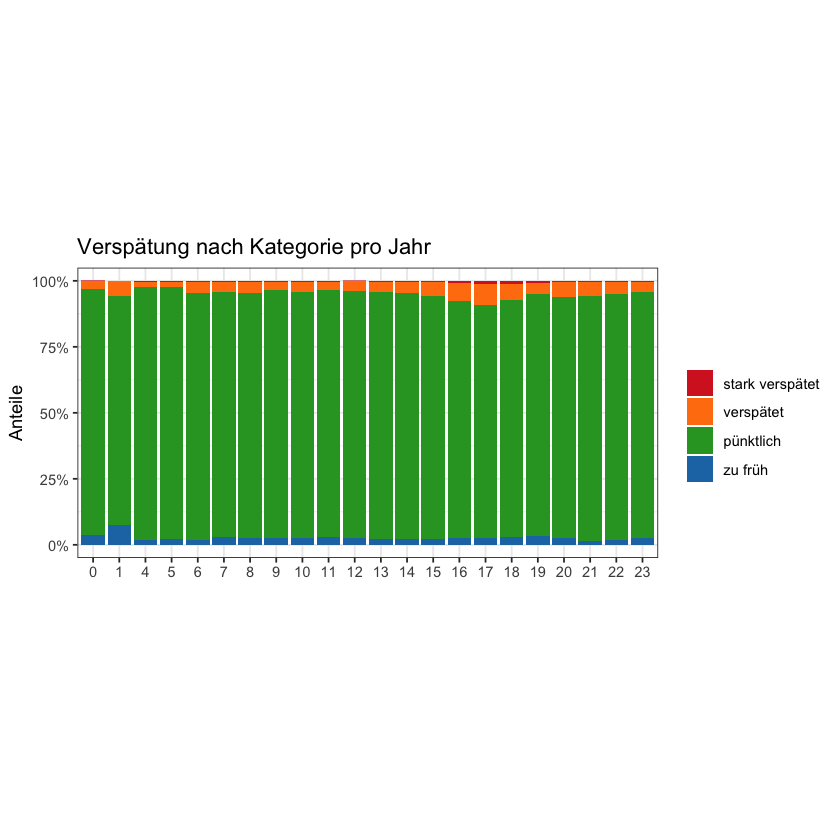

In [96]:
data_hour <- data_classified

alpha <- 0.05
output_path <- "/Users/JonasIseli/Desktop"

# Überprüfung der Varianzhomogenität mittels Bartlett-Test
result_bartlett <- bartlett.test(verspaetung ~hour, data = data_hour)

if(result_bartlett$p.value < alpha) {
    print('Reject H0: Variances are not equal')
    print("Performing Welch's ANOVA")
    model <- oneway.test(verspaetung ~hour, data = data_hour)
}else{
    print('Accept H0: Variances are equal')
    print("Performing ANOVA")
    model <- aov(verspaetung ~hour, data = data_hour)
}
model

if(model$p.value < alpha) {
    print('Reject H0: There is a significant difference between the groups')
    print("Post Hoc test")

    post_hoc <- with(data_hour,
         pairwise.t.test(verspaetung, hour))
    post_hoc
}else{
    print('Accept H0: There is no significant difference between the groups')
}

post_hoc$p.value %>%
    as_data_frame() %>% 
    rownames_to_column(var = "hour") %>% 
    write_csv(file.path(output_path,"verspaetung_hour_post_hoc.csv"))


# Zusammenfassung
data_hour %>% 
group_by(hour) %>% 
summarise(
    mean = mean(verspaetung),
    median = median(verspaetung),
    sd = sd(verspaetung),
    n = n()
    ) %>%
    # adjust path
    write_csv(file.path(output_path, "verspaetung_per_hour_summary.csv"))

# Prozent Anteile der Verspätungskategorien pro Stunde
data_hour %>%
    count(hour, verspaetung_cat) %>%
    group_by(hour) %>%
    mutate(
        perc = round(n / sum(n)*100,2)
    ) %>%
    select(-n) %>%
    pivot_wider(names_from = hour, values_from = perc) %>%
    # adjust path
    write_csv(file.path(output_path, "verspaetung_cat_per_hour_percentage.csv"))


# Plot - Color Palette
delay_colors <- c(
  "-1" = "#1f77b4",  # Too Early
  "0" = "#2ca02c",   # On Time
  "1" = "#ff7f0e",   # Late
  "2" = "#d62728"    # Very Late
)

# Plot
data_hour %>%
    ggplot(
        aes(
            x = hour,
            fill = verspaetung_cat,
        )
    )+

    geom_bar(
        position = "fill"
    )+

    scale_y_continuous(
        labels = scales::percent_format()
    )+

    scale_fill_manual(
        name = "",
        values = delay_colors,
        labels = c("stark verspätet", "verspätet", "pünktlich", "zu früh")
    )+

    labs(
        title = "Verspätung nach Kategorie pro Jahr",
        x = "",
        y = "Anteile"
    )+

    theme_bw()+

    theme(
        aspect.ratio = 0.5
    )
    # save plot
    ggsave(
        file.path(output_path, "Plot_verspaetung_cat_per_hour_percentage.png"),
        dpi = 1000

    )

### Einfluss des Fahrzeugtyps auf die Verspätung

[1] "Reject H0: Variances are not equal"
[1] "Performing Welch's ANOVA"



	One-way analysis of means (not assuming equal variances)

data:  verspaetung and tramtyp_id
F = 332.26, num df = 3.0, denom df = 1572.3, p-value < 2.2e-16


[1] "Reject H0: There is a significant difference between the groups"
[1] "Post Hoc test"



	Pairwise comparisons using t tests with pooled SD 

data:  verspaetung and tramtyp_id 

  1      2      3     
2 <2e-16 -      -     
3 <2e-16 0.95   -     
4 <2e-16 <2e-16 <2e-16

P value adjustment method: holm 

Saving 7 x 7 in image


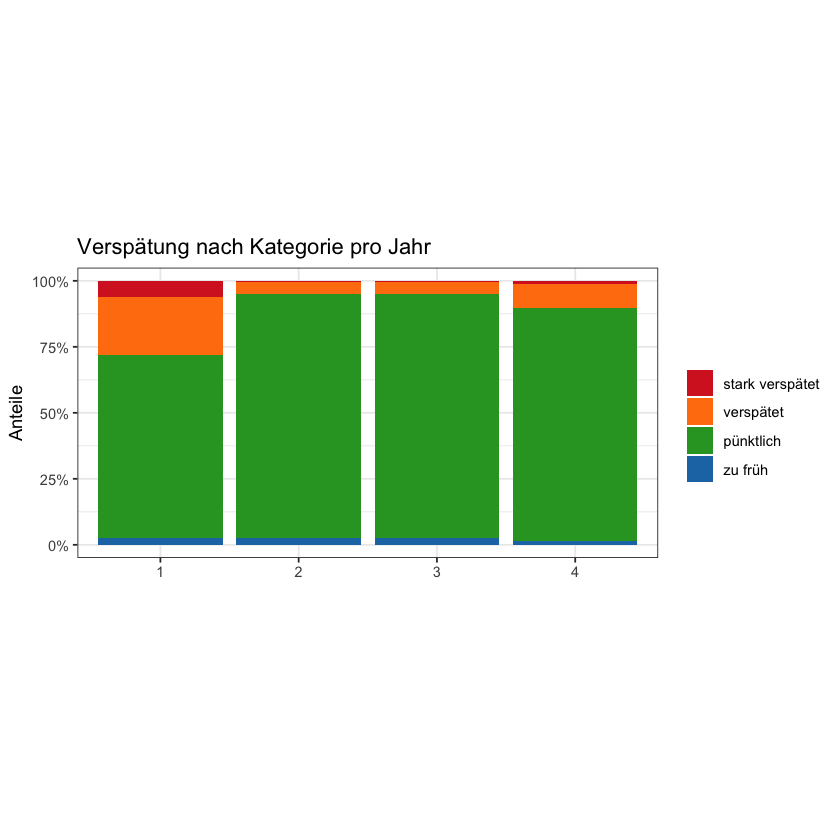

In [97]:
data_fahrzeug <- data_classified %>% drop_na(tramtyp_id)

alpha <- 0.05
output_path <- "/Users/JonasIseli/Desktop"

# Überprüfung der Varianzhomogenität mittels Bartlett-Test
result_bartlett <- bartlett.test(verspaetung ~tramtyp_id, data = data_fahrzeug)

if(result_bartlett$p.value < alpha) {
    print('Reject H0: Variances are not equal')
    print("Performing Welch's ANOVA")
    model <- oneway.test(verspaetung ~tramtyp_id, data = data_fahrzeug)
}else{
    print('Accept H0: Variances are equal')
    print("Performing ANOVA")
    model <- aov(verspaetung ~tramtyp_id, data = data_fahrzeug)
}
model

if(model$p.value < alpha) {
    print('Reject H0: There is a significant difference between the groups')
    print("Post Hoc test")

    post_hoc <- with(data_fahrzeug,
         pairwise.t.test(verspaetung, tramtyp_id))
    post_hoc
}else{
    print('Accept H0: There is no significant difference between the groups')
}

post_hoc$p.value %>%
    as_data_frame() %>% 
    rownames_to_column(var = "tramtyp_id") %>% 
    write_csv(file.path(output_path,"verspaetung_tramtyp_id_post_hoc.csv"))


# Zusammenfassung
data_fahrzeug %>% 
group_by(tramtyp_id) %>% 
summarise(
    mean = mean(verspaetung),
    median = median(verspaetung),
    sd = sd(verspaetung),
    n = n()
    ) %>%
    # adjust path
    write_csv(file.path(output_path, "verspaetung_per_tramtyp_id_summary.csv"))

# Prozent Anteile der Verspätungskategorien pro Stunde
data_fahrzeug %>%
    count(tramtyp_id, verspaetung_cat) %>%
    group_by(tramtyp_id) %>%
    mutate(
        perc = round(n / sum(n)*100,2)
    ) %>%
    select(-n) %>%
    pivot_wider(names_from = tramtyp_id, values_from = perc) %>%
    # adjust path
    write_csv(file.path(output_path, "verspaetung_cat_per_tramtyp_id_percentage.csv"))


# Plot - Color Palette
delay_colors <- c(
  "-1" = "#1f77b4",  # Too Early
  "0" = "#2ca02c",   # On Time
  "1" = "#ff7f0e",   # Late
  "2" = "#d62728"    # Very Late
)

# Plot
data_fahrzeug %>%
    ggplot(
        aes(
            x = tramtyp_id,
            fill = verspaetung_cat,
        )
    )+

    geom_bar(
        position = "fill"
    )+

    scale_y_continuous(
        labels = scales::percent_format()
    )+

    scale_fill_manual(
        name = "",
        values = delay_colors,
        labels = c("stark verspätet", "verspätet", "pünktlich", "zu früh")
    )+

    labs(
        title = "Verspätung nach Kategorie pro Jahr",
        x = "",
        y = "Anteile"
    )+

    theme_bw()+

    theme(
        aspect.ratio = 0.5
    )
    # save plot
    ggsave(
        file.path(output_path, "Plot_verspaetung_cat_per_tramtyp_id_percentage.png"),
        dpi = 1000

    )